# TODO

- Weighted cross entropy lossの実装

# Setting

In [1]:
import sys

import polars as pl
import seaborn as sns

root_dir = "../../"
if root_dir not in sys.path:
    sys.path.append(root_dir)
from modules import config as cfg
from modules import utils, preprosess, training, predict, metrics

exp = "exp08"
utils.set_seed(cfg.Params.seed)

# Read data

In [2]:
train, test, submit = utils.get_data(debug_mode=False)

# Preprocessing

## Split fold

In [3]:
train = preprosess.assign_stratified_k_fold(train, "MIS_Status")

## Convert

In [4]:
# Cityを座標に変換
train = preprosess.convert_city_to_latlon(train)
test  = preprosess.convert_city_to_latlon(test)

# testのBankStateの"PR"はtrainにないため，一番多いCAに変換
test = test.with_columns(pl.col("BankState").str.replace("PR", "CA"))

# DisbursementDateとApprovalDateをYear(数値)に変換
cols  = ["DisbursementDate", "ApprovalDate"]
train = preprosess.convert_date_to_year(train, cols)
test  = preprosess.convert_date_to_year(test, cols)

# 金額データの数値化
cols  = ["DisbursementGross",  "GrAppv", "SBA_Appv"]
train = preprosess.convert_money_data(train, cols)
test  = preprosess.convert_money_data(test, cols)

# 一致しているか
eqs = [
    ["State", "BankState"],
]
train = preprosess.add_eq(train, eqs)
test  = preprosess.add_eq(test, eqs)

# 差の計算
diffs = [
    ["DisbursementGross", "GrAppv"],   # 支払われた額 vs 銀行承認額
    ["DisbursementGross", "SBA_Appv"], # 支払われた額 vs SBA承認額
    ["GrAppv", "SBA_Appv"],            # 銀行承認額 vs SBA承認額
]
train = preprosess.add_diff(train, diffs)
test  = preprosess.add_diff(test, diffs)

# DisbursementDateとApprovalDateの差を計算
train = preprosess.add_diff_disbursement_with_approval(train)
test  = preprosess.add_diff_disbursement_with_approval(test)

# 割合の計算
divs = [
    # ["DisbursementGross", "Term"],
    ["GrAppv", "Term"],
    ["SBA_Appv", "Term"],
    ["NoEmp", "Term"],
    # ["DisbursementGross", "NoEmp"],
    # ["GrAppv", "NoEmp"],
    # ["SBA_Appv", "NoEmp"],
    ["DisbursementGross_GrAppv_diff", "Term"],
    ["DisbursementGross_SBA_Appv_diff", "Term"],
    ["GrAppv_SBA_Appv_diff", "Term"],
    # ["DisbursementGross_GrAppv_diff", "NoEmp"],
    # ["DisbursementGross_SBA_Appv_diff", "NoEmp"],
    # ["GrAppv_SBA_Appv_diff", "NoEmp"]
]
train = preprosess.add_div(train, divs)
test  = preprosess.add_div(test, divs)

# Sectorを職業別にする
train = preprosess.unify_same_sector(train)
test  = preprosess.unify_same_sector(test)

## Target encoding

In [5]:
cols = [
    # "Sector",
    "UrbanRural",
    "RevLineCr",
    "LowDoc",
    "FranchiseCode",
]
target_col = "MIS_Status"
train, test = preprosess.target_encoding(train, test, cols)

## Label encoding
CVによるtarget encodingでは同じカテゴリカル変数に異なる値が割り当てられるのでlabel encodingを併用する

In [6]:
cols = ["RevLineCr", "LowDoc"]
train, test = preprosess.label_encoding(train, test, cols)

# Drop columns

In [7]:
# 不要なカラムの削除
del_cols = [
    # 地名系
    "City",
    "State",
    "BankState",
    # d-b-y系
    "DisbursementDate",
    "ApprovalDate",
    "ApprovalFY",
    # ラベルエンコーディング済み
    "RevLineCr",
    "LowDoc",
]
train = train.drop(del_cols)
test  = test.drop(del_cols)

# Training

In [8]:
lgb_params = {
    'objective': 'binary',
    'metric': 'custom',
    'boosting_type': 'gbdt',
    'seed': cfg.Params.seed,
    'learning_rate': cfg.Params.learning_rate,
}
oof, models = training.fit_lgbm_wcel(train, lgb_params=lgb_params)

--------------------------------------------------------------------------------
START fold 1
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4971
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.25: 0.10952	valid_1's WCE_alpha0.25: 0.170432
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.25: 0.10952	valid_1's WCE_alpha0.25: 0.170432
Time:  4.245[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.25: 0.109708	valid_1's WCE_alpha0.25: 0.171552
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.25: 0.109708	valid_1's WCE_alpha0.25: 0.171552
Time:  4.241[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010379 seconds.
You can set `force_row_wise=true` to remove the overhe

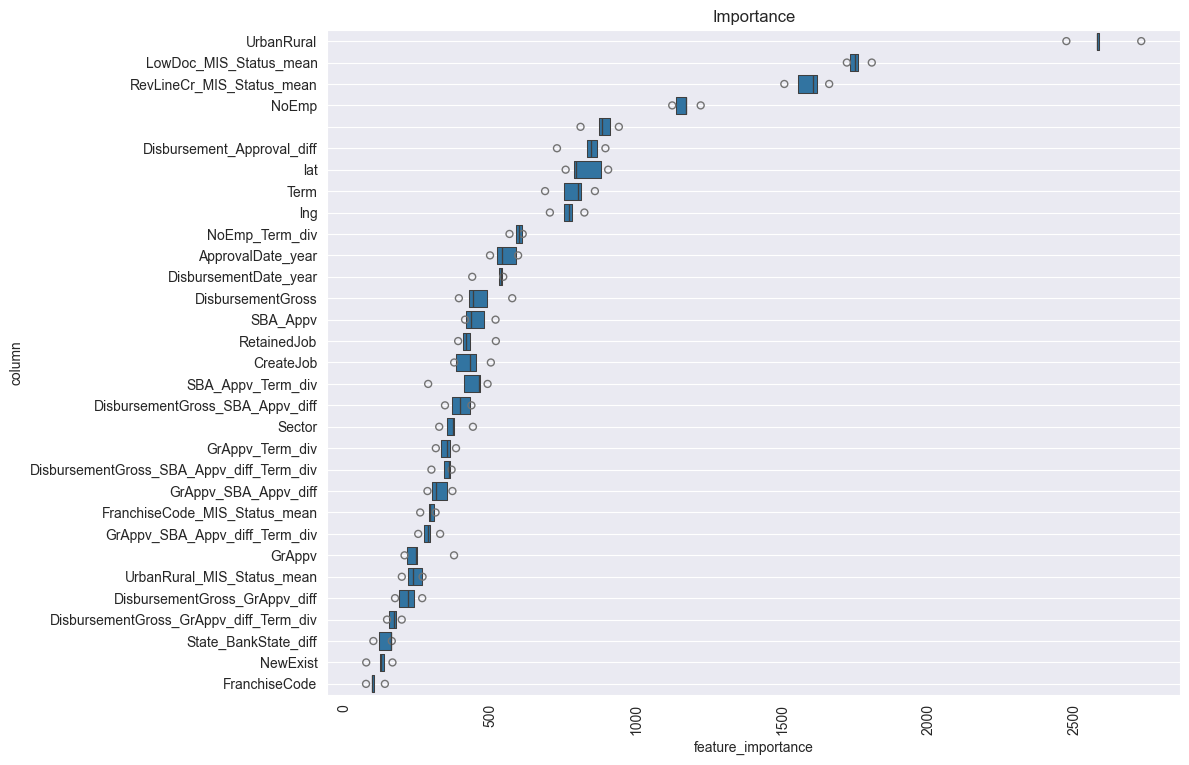

In [9]:
fig, ax = training.show_feature_importance(models, train)

# Predict

In [10]:
pred_prob = predict.predict_probability(models, test)
pred_class = predict.predict_class_sigmoid(pred_prob)

## CV score

In [11]:
oof_truth = train[cfg.Cols.target].to_numpy()
oof_hat = predict.predict_class(oof)
cv_score = metrics.macro_f1_score(oof_truth, oof_hat)
print(cv_score)

0.6426630527805643


## Check result

### oofとtestの予測値分布を比較してバグを確認

<Axes: ylabel='Count'>

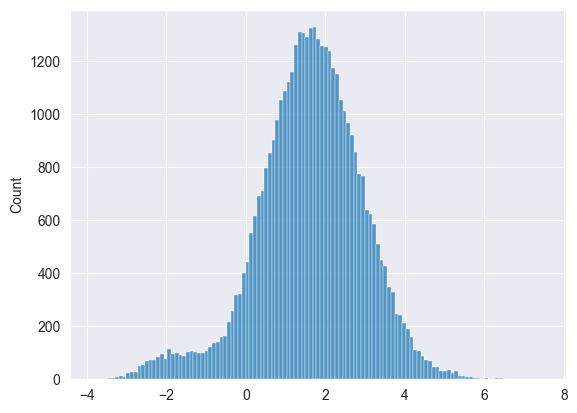

In [12]:
sns.histplot(oof)

<Axes: ylabel='Count'>

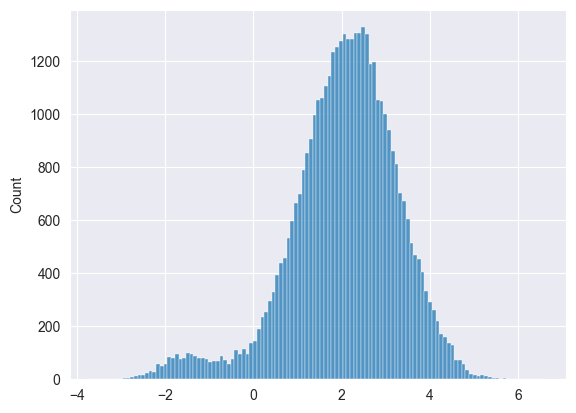

In [13]:
sns.histplot(pred_prob)

### 予測値の1の割合を確認

In [14]:
print(pred_class.sum() / len(pred_class))

0.8379794434892499


### oofにおける混同行列を確認

True Negative Rate (0の正解率): 0.51
True Positive Rate (1の正解率): 0.87


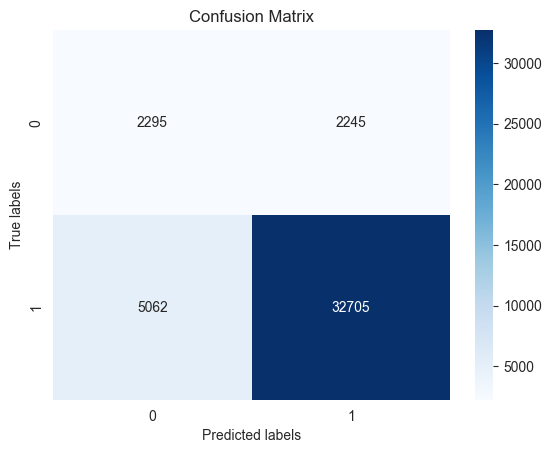

In [15]:
metrics.show_confusion_matrix(oof_truth, oof_hat)

## Submit

In [16]:
submit = submit.with_columns([pl.Series(cfg.Cols.sub_pred, pred_class)])
utils.make_submission(submit, exp, cv_score)